## Udacity Intro to Machine (Ud-120) Learning Final Project

**Objective:** Attempt to identify persons of interest (POIs) from the Enron financial fraud investigation based on financial and and summary email data. The data are provided, with POIs identified. The data, unfortunately, have many missing values, resulting in small final dataset.

In [90]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [88]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# Take a look at the layout of the dictionary
print(data_dict['METTS MARK'])

{'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'loan_advances': 'NaN', 'bonus': 600000, 'email_address': 'mark.metts@enron.com', 'restricted_stock_deferred': 'NaN', 'deferred_income': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'from_poi_to_this_person': 38, 'exercised_stock_options': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'long_term_incentive': 'NaN', 'shared_receipt_with_poi': 702, 'restricted_stock': 585062, 'director_fees': 'NaN'}


In [89]:
# get rid of their dict/list structure and use dataframe
enron = pd.DataFrame.from_dict(data_dict, orient='index')
enron.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN


In [4]:
display(enron.info())

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   salary                     146 non-null    object
 1   to_messages                146 non-null    object
 2   deferral_payments          146 non-null    object
 3   total_payments             146 non-null    object
 4   loan_advances              146 non-null    object
 5   bonus                      146 non-null    object
 6   email_address              146 non-null    object
 7   restricted_stock_deferred  146 non-null    object
 8   deferred_income            146 non-null    object
 9   total_stock_value          146 non-null    object
 10  expenses                   146 non-null    object
 11  from_poi_to_this_person    146 non-null    object
 12  exercised_stock_options    146 non-null    object
 13  from_messages              146 non-null    object

None

In [5]:
# convert the numeric data to float, since that can handle the NaNs
cols = enron.columns
display(cols)
cols_nonint = ['email_address', 'poi']

for col in cols:
    if col in cols_nonint:
        continue
    else:
        enron[col] = enron[col].astype('float64')

enron.info()

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     95 non-null     float64
 1   to_messages                86 non-null     float64
 2   deferral_payments          39 non-null     float64
 3   total_payments             125 non-null    float64
 4   loan_advances              4 non-null      float64
 5   bonus                      82 non-null     float64
 6   email_address              146 non-null    object 
 7   restricted_stock_deferred  18 non-null     float64
 8   deferred_income            49 non-null     float64
 9   total_stock_value          126 non-null    float64
 10  expenses                   95 non-null     float64
 11  from_poi_to_this_person    86 non-null     float64
 12  exercised_stock_options    102 non-null    float64
 13  from_messages              86 non-

In [6]:
enron.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,9.500000e+01,86.000000,3.900000e+01,1.250000e+02,4.000000e+00,8.200000e+01,1.800000e+01,4.900000e+01,1.260000e+02,9.500000e+01,86.000000,1.020000e+02,86.000000,9.300000e+01,86.000000,6.600000e+01,86.000000,1.100000e+02,1.700000e+01
mean,5.621943e+05,2073.860465,1.642674e+06,5.081526e+06,4.196250e+07,2.374235e+06,1.664106e+05,-1.140475e+06,6.773957e+06,1.087289e+05,64.895349,5.987054e+06,608.790698,9.190650e+05,41.232558,1.470361e+06,1176.465116,2.321741e+06,1.668049e+05
std,2.716369e+06,2582.700981,5.161930e+06,2.906172e+07,4.708321e+07,1.071333e+07,4.201494e+06,4.025406e+06,3.895777e+07,5.335348e+05,86.979244,3.106201e+07,1841.033949,4.589253e+06,100.073111,5.942759e+06,1178.317641,1.251828e+07,3.198914e+05
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-7.576788e+06,-2.799289e+07,-4.409300e+04,1.480000e+02,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3.285000e+03
25%,2.118160e+05,541.250000,8.157300e+04,3.944750e+05,1.600000e+06,4.312500e+05,-3.896218e+05,-6.948620e+05,4.945102e+05,2.261400e+04,10.000000,5.278862e+05,22.750000,1.215000e+03,1.000000,2.812500e+05,249.750000,2.540180e+05,9.878400e+04
50%,2.599960e+05,1211.000000,2.274490e+05,1.101393e+06,4.176250e+07,7.693750e+05,-1.469750e+05,-1.597920e+05,1.102872e+06,4.695000e+04,35.000000,1.310814e+06,41.000000,5.238200e+04,8.000000,4.420350e+05,740.500000,4.517400e+05,1.085790e+05
75%,3.121170e+05,2634.750000,1.002672e+06,2.093263e+06,8.212500e+07,1.200000e+06,-7.500975e+04,-3.834600e+04,2.949847e+06,7.995250e+04,72.250000,2.547724e+06,145.500000,3.620960e+05,24.750000,9.386720e+05,1888.250000,1.002370e+06,1.137840e+05
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,-8.330000e+02,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,609.000000,4.852193e+07,5521.000000,1.303223e+08,1.398517e+06


The dataset is not large (146 people) and there appear to be quite a few missing/NaN entries, e.g. salary data for 51 people, bonus data for 64, email for 60.

There are some very high max numbers for all of the salary/payment columns. 
In earlier lessons, there was a "TOTAL" column erroneously in the data. 
See if that and any other non-people are in the list.

In [7]:
enron.index[0:50]

Index(['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R',
       'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G',
       'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'PIPER GREGORY F',
       'HUMPHREY GENE E', 'NOLES JAMES L', 'BLACHMAN JEREMY M', 'SUNDE MARTIN',
       'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S',
       'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W',
       'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT',
       'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P',
       'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H',
       'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B',
       'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W',
       'LEWIS RICHARD', 'HAYES ROBERT E', 'KOPPER MICHAEL J', 'LEFF DANIEL P',
       'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J',
       'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE

In [8]:
enron.index[51:100]

Index(['SHERRIFF JOHN R', 'SHELBY REX', 'LEMAISTRE CHARLES',
       'DEFFNER JOSEPH M', 'KISHKILL JOSEPH G', 'WHALLEY LAWRENCE G',
       'MCCONNELL MICHAEL S', 'PIRO JIM', 'DELAINEY DAVID W',
       'SULLIVAN-SHAKLOVITZ COLLEEN', 'WROBEL BRUCE', 'LINDHOLM TOD A',
       'MEYER JEROME J', 'LAY KENNETH L', 'BUTTS ROBERT H', 'OLSON CINDY K',
       'MCDONALD REBECCA', 'CUMBERLAND MICHAEL S', 'GAHN ROBERT S',
       'BADUM JAMES P', 'HERMANN ROBERT J', 'FALLON JAMES B',
       'GATHMANN WILLIAM D', 'HORTON STANLEY C', 'BOWEN JR RAYMOND M',
       'GILLIS JOHN', 'FITZGERALD JAY L', 'MORAN MICHAEL P', 'REDMOND BRIAN L',
       'BAZELIDES PHILIP J', 'BELDEN TIMOTHY N', 'DIMICHELE RICHARD G',
       'DURAN WILLIAM D', 'THORN TERENCE H', 'FASTOW ANDREW S', 'FOY JOE',
       'CALGER CHRISTOPHER F', 'RICE KENNETH D', 'KAMINSKI WINCENTY J',
       'LOCKHART EUGENE E', 'COX DAVID', 'OVERDYKE JR JERE C',
       'PEREIRA PAULO V. FERRAZ', 'STABLER FRANK', 'SKILLING JEFFREY K',
       'BLAKE JR. NORM

In [9]:
enron.index[101:145]

Index(['UMANOFF ADAM S', 'KEAN STEVEN J', 'TOTAL', 'FOWLER PEGGY',
       'WASAFF GEORGE', 'WHITE JR THOMAS E', 'CHRISTODOULOU DIOMEDES',
       'ALLEN PHILLIP K', 'SHARP VICTORIA T', 'JAEDICKE ROBERT',
       'WINOKUR JR. HERBERT S', 'BROWN MICHAEL', 'MCCLELLAN GEORGE',
       'HUGHES JAMES A', 'REYNOLDS LAWRENCE', 'PICKERING MARK R',
       'BHATNAGAR SANJAY', 'CARTER REBECCA C', 'BUCHANAN HAROLD G',
       'YEAP SOON', 'MURRAY JULIA H', 'GARLAND C KEVIN', 'DODSON KEITH',
       'YEAGER F SCOTT', 'HIRKO JOSEPH', 'DIETRICH JANET R',
       'DERRICK JR. JAMES V', 'FREVERT MARK A', 'PAI LOU L',
       'HAYSLETT RODERICK J', 'BAY FRANKLIN R', 'MCCARTY DANNY J',
       'FUGH JOHN L', 'SCRIMSHAW MATTHEW', 'KOENIG MARK E', 'SAVAGE FRANK',
       'IZZO LAWRENCE L', 'TILNEY ELIZABETH A', 'MARTIN AMANDA K',
       'BUY RICHARD B', 'GRAMM WENDY L', 'CAUSEY RICHARD A',
       'TAYLOR MITCHELL S', 'DONAHUE JR JEFFREY M'],
      dtype='object')

In [10]:
enron.loc["TOTAL",:]

salary                       2.67042e+07
to_messages                          NaN
deferral_payments            3.20834e+07
total_payments               3.09887e+08
loan_advances                 8.3925e+07
bonus                        9.73436e+07
email_address                        NaN
restricted_stock_deferred   -7.57679e+06
deferred_income             -2.79929e+07
total_stock_value             4.3451e+08
expenses                      5.2352e+06
from_poi_to_this_person              NaN
exercised_stock_options      3.11764e+08
from_messages                        NaN
other                        4.26676e+07
from_this_person_to_poi              NaN
poi                                False
long_term_incentive          4.85219e+07
shared_receipt_with_poi              NaN
restricted_stock             1.30322e+08
director_fees                1.39852e+06
Name: TOTAL, dtype: object

Delete the "TOTAL" entry.

In [11]:
enron.drop('TOTAL', axis = 0, inplace=True)

In [12]:
enron.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,9.400000e+01,86.000000,3.800000e+01,1.240000e+02,3.000000e+00,8.100000e+01,1.700000e+01,4.800000e+01,1.250000e+02,94.000000,86.000000,1.010000e+02,86.000000,9.200000e+01,86.000000,6.500000e+01,86.000000,1.090000e+02,16.000000
mean,2.840875e+05,2073.860465,8.416025e+05,2.623421e+06,2.797500e+07,1.201773e+06,6.218928e+05,-5.810498e+05,3.352073e+06,54192.010638,64.895349,2.959559e+06,608.790698,4.652767e+05,41.232558,7.464912e+05,1176.465116,1.147424e+06,89822.875000
std,1.771311e+05,2582.700981,1.289323e+06,9.488106e+06,4.638256e+07,1.441679e+06,3.845528e+06,9.420764e+05,6.532883e+06,46108.377454,86.979244,5.499450e+06,1841.033949,1.389719e+06,100.073111,8.629174e+05,1178.317641,2.249770e+06,41112.700735
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-1.787380e+06,-3.504386e+06,-4.409300e+04,148.000000,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3285.000000
25%,2.118020e+05,541.250000,7.964450e+04,3.863802e+05,1.200000e+06,4.250000e+05,-3.298250e+05,-6.112092e+05,4.941360e+05,22479.000000,10.000000,5.067650e+05,22.750000,1.209000e+03,1.000000,2.750000e+05,249.750000,2.520550e+05,83674.500000
50%,2.587410e+05,1211.000000,2.210635e+05,1.100246e+06,2.000000e+06,7.500000e+05,-1.402640e+05,-1.519270e+05,1.095040e+06,46547.500000,35.000000,1.297049e+06,41.000000,5.198450e+04,8.000000,4.221580e+05,740.500000,4.410960e+05,106164.500000
75%,3.086065e+05,2634.750000,8.672112e+05,2.084663e+06,4.176250e+07,1.200000e+06,-7.241900e+04,-3.792600e+04,2.606763e+06,78408.500000,72.250000,2.542813e+06,145.500000,3.575772e+05,24.750000,8.318090e+05,1888.250000,9.850320e+05,112815.000000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,8.152500e+07,8.000000e+06,1.545629e+07,-8.330000e+02,4.911008e+07,228763.000000,528.000000,3.434838e+07,14368.000000,1.035973e+07,609.000000,5.145434e+06,5521.000000,1.476169e+07,137864.000000


#### Selecting Features of Interest & Creating New Features

Plot distributions and plot features vs. POI status using bar plots to try to discern which features are associated with POI status

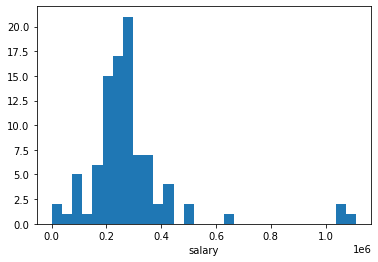

In [13]:
plt.hist(data=enron, x='salary', bins=30)
plt.xlabel("salary");

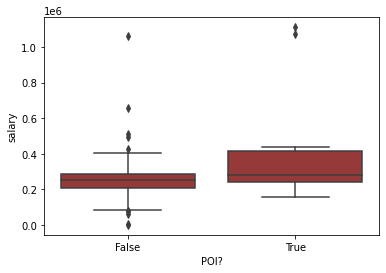

In [14]:
sb.boxplot(data=enron, x='poi', y='salary', color='brown')
plt.ylabel('salary')
plt.xlabel('POI?');

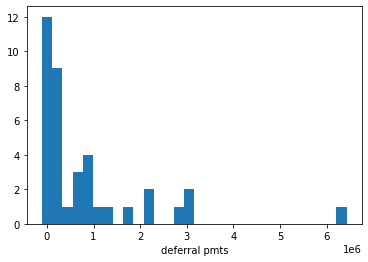

In [15]:
plt.hist(data=enron, x='deferral_payments', bins=30)
plt.xlabel("deferral pmts");

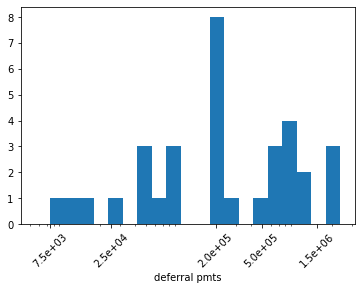

In [16]:
bins = 10**np.arange(3.75,6.5,0.125)
plt.hist(data=enron, x='deferral_payments', bins=bins)
plt.xscale("log")
plt.xlabel("deferral pmts")
new_tix = [7500, 25000, 200000, 500000, 1500000]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

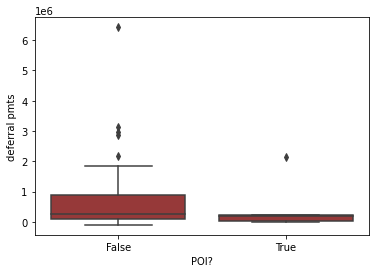

In [17]:
sb.boxplot(data=enron, x='poi', y='deferral_payments', color='brown')
plt.ylabel('deferral pmts')
plt.xlabel('POI?');

In [18]:
enron[enron['deferral_payments']<0]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
BELFER ROBERT,NaN,NaN,-102500.0,102500.0,NaN,NaN,NaN,44093.0,NaN,-44093.0,...,NaN,3285.0,NaN,NaN,NaN,False,NaN,NaN,NaN,3285.0


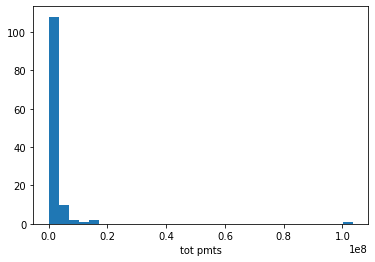

In [19]:
plt.hist(data=enron, x='total_payments', bins=30)
plt.xlabel('tot pmts');

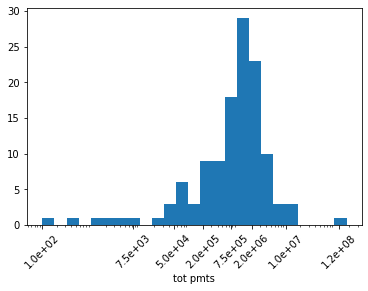

In [20]:
bins = 10**np.arange(2,8.5,0.25)
plt.hist(data=enron, x='total_payments', bins=bins)
plt.xscale("log")
plt.xlabel("tot pmts")
new_tix = [1e2, 7.5e3, 5e4, 2e5, 7.5e5, 2e6, 1e7, 1.25e8]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

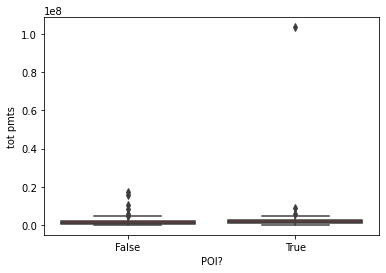

In [21]:
sb.boxplot(data=enron, x='poi', y='total_payments', color='brown')
plt.ylabel('tot pmts')
plt.xlabel('POI?');

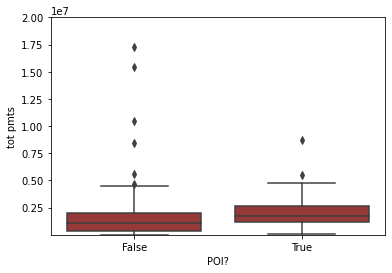

In [22]:
sb.boxplot(data=enron, x='poi', y='total_payments', color='brown')
plt.ylim(1e3, 2e7)
plt.ylabel('tot pmts')
plt.xlabel('POI?');

In [23]:
enron[enron['total_payments']>2e7]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,81525000.0,7000000.0,kenneth.lay@enron.com,NaN,-300000.0,49110078.0,...,123.0,34348384.0,36.0,10359729.0,16.0,True,3600000.0,2411.0,14761694.0,NaN


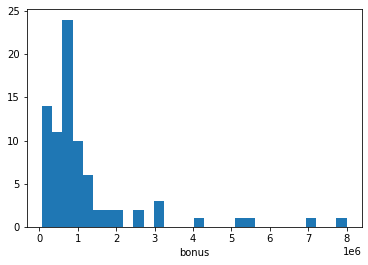

In [24]:
plt.hist(data=enron, x='bonus', bins=30)
plt.xlabel('bonus');

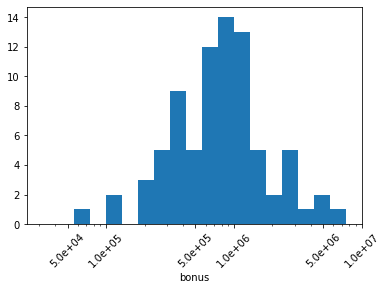

In [25]:
bins = 10**np.arange(4.5,7,0.125)
plt.hist(data=enron, x='bonus', bins=bins)
plt.xscale("log")
plt.xlabel("bonus")
new_tix = [5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

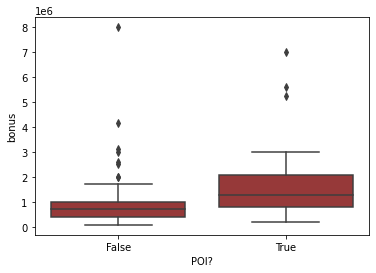

In [26]:
sb.boxplot(data=enron, x='poi', y='bonus', color='brown')
plt.ylabel('bonus')
plt.xlabel('POI?');

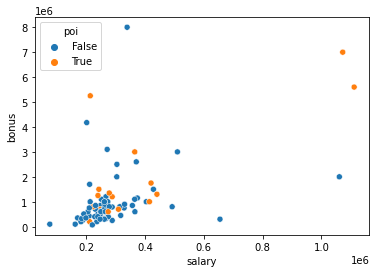

In [27]:
sb.scatterplot(data=enron, x='salary', y='bonus', hue='poi');

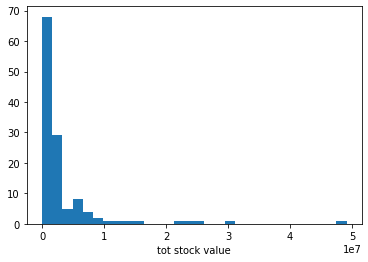

In [28]:
plt.hist(data=enron, x='total_stock_value', bins=30)
plt.xlabel('tot stock value');

In [29]:
enron[enron['total_stock_value']<0]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
BELFER ROBERT,NaN,NaN,-102500.0,102500.0,NaN,NaN,NaN,44093.0,NaN,-44093.0,...,NaN,3285.0,NaN,NaN,NaN,False,NaN,NaN,NaN,3285.0


Stock/tot pmts might be more reflective on how income dep on stock but eg Lay is massive outlier in tot pmts due to $80M loan, so will look at stock/salary instead

In [30]:
enron['stock/sal']=enron['total_stock_value']/enron['salary']

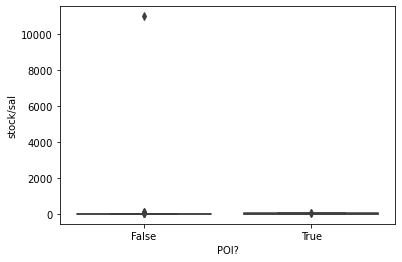

In [31]:
sb.boxplot(data=enron, x='poi', y='stock/sal', color='brown')
plt.ylabel('stock/sal')
plt.xlabel('POI?');

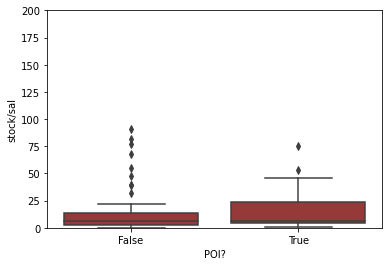

In [32]:
sb.boxplot(data=enron, x='poi', y='stock/sal', color='brown')
plt.ylim(0,200)
plt.ylabel('stock/sal')
plt.xlabel('POI?');

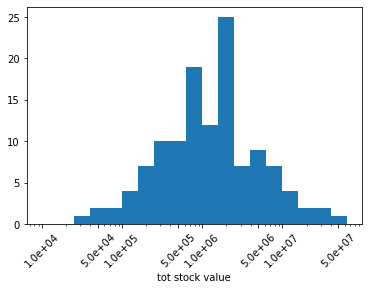

In [33]:
bins = 10**np.arange(4,8,0.2)
plt.hist(data=enron, x='total_stock_value', bins=bins)
plt.xscale("log")
plt.xlabel("tot stock value")
new_tix = [1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7, 5e7]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

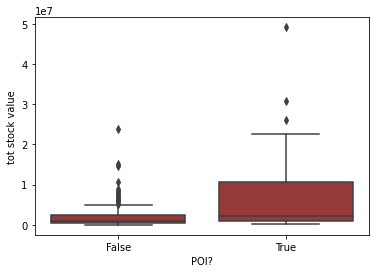

In [34]:
sb.boxplot(data=enron, x='poi', y='total_stock_value', color='brown')
plt.ylabel('tot stock value')
plt.xlabel('POI?');

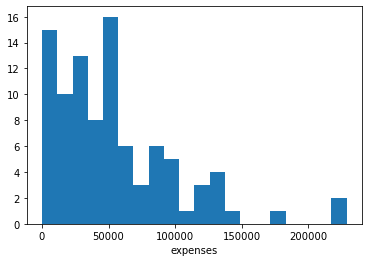

In [35]:
plt.hist(data=enron, x='expenses', bins=20)
plt.xlabel('expenses');

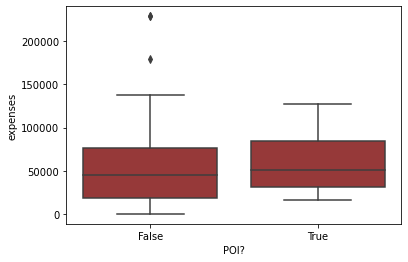

In [36]:
sb.boxplot(data=enron, x='poi', y='expenses', color='brown')
plt.ylabel('expenses')
plt.xlabel('POI?');

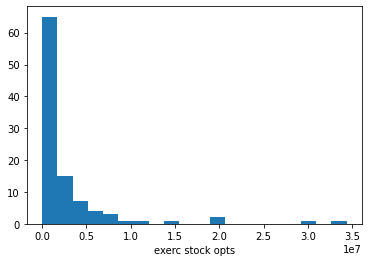

In [37]:
plt.hist(data=enron, x='exercised_stock_options', bins=20)
plt.xlabel('exerc stock opts');

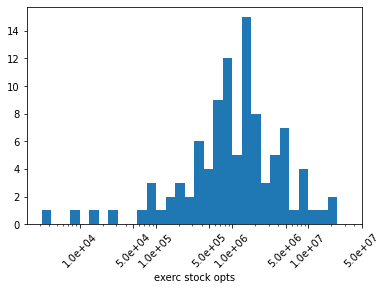

In [38]:
bins = 10**np.arange(3.5,7.5,0.125)
plt.hist(data=enron, x='exercised_stock_options', bins=bins)
plt.xscale("log")
plt.xlabel("exerc stock opts")
new_tix = [1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7, 5e7]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

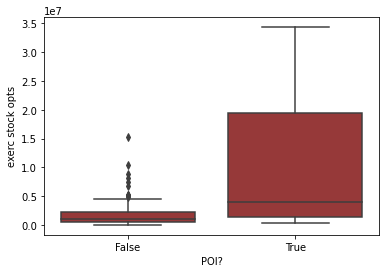

In [39]:
sb.boxplot(data=enron, x='poi', y='exercised_stock_options', color='brown')
plt.ylabel('exerc stock opts')
plt.xlabel('POI?');

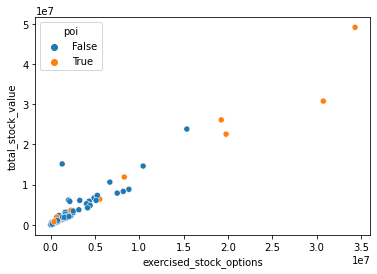

In [40]:
sb.scatterplot(data=enron, x='exercised_stock_options', y='total_stock_value', hue='poi');

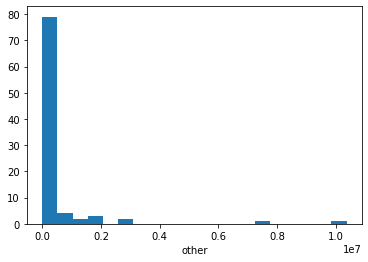

In [41]:
plt.hist(data=enron, x='other', bins=20)
plt.xlabel('other');

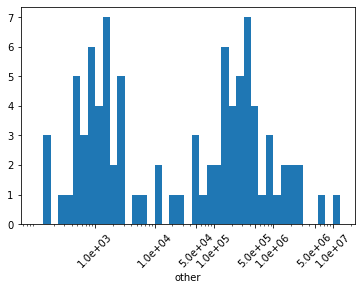

In [42]:
bins = 10**np.arange(2,7.25,0.125)
plt.hist(data=enron, x='other', bins=bins)
plt.xscale("log")
plt.xlabel("other")
new_tix = [1e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

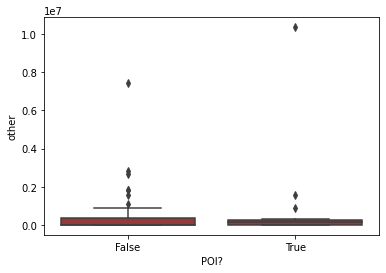

In [43]:
sb.boxplot(data=enron, x='poi', y='other', color='brown')
plt.ylabel('other')
plt.xlabel('POI?');

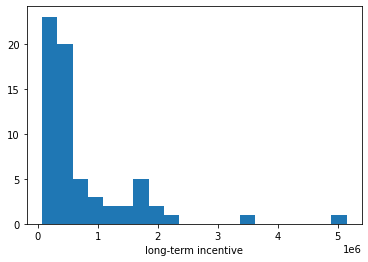

In [44]:
plt.hist(data=enron, x='long_term_incentive', bins=20)
plt.xlabel('long-term incentive');

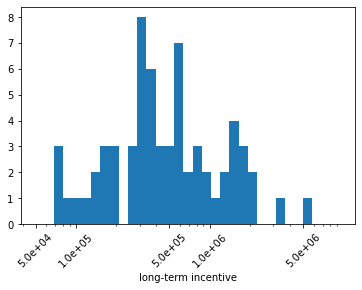

In [45]:
bins = 10**np.arange(4.7,7,0.069)
plt.hist(data=enron, x='long_term_incentive', bins=bins)
plt.xscale("log")
plt.xlabel("long-term incentive")
new_tix = [5e4, 1e5, 5e5, 1e6, 5e6]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

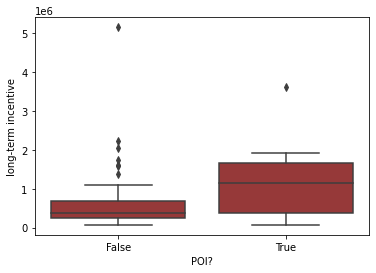

In [46]:
sb.boxplot(data=enron, x='poi', y='long_term_incentive', color='brown')
plt.ylabel('long-term incentive')
plt.xlabel('POI?');

Holding lots of stock and having a big long-term incentive would both be incentives to keep Co afloat & stock price up, which seems to have driven a lot of the shady dealings

In [47]:
enron['stock+lti']=enron['total_stock_value']+enron['long_term_incentive']

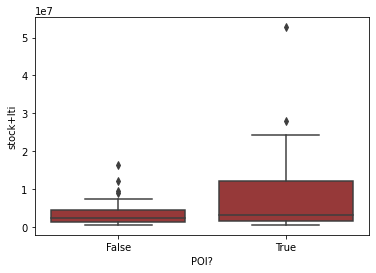

In [48]:
sb.boxplot(data=enron, x='poi', y='stock+lti', color='brown')
plt.ylabel('stock+lti')
plt.xlabel('POI?');

In [49]:
enron['stock+lti/sal']=enron['stock+lti']/enron['salary']

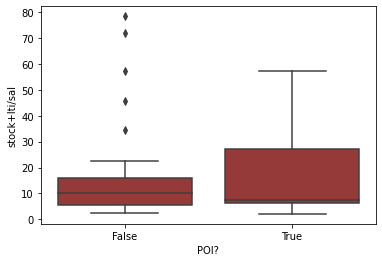

In [50]:
sb.boxplot(data=enron, x='poi', y='stock+lti/sal', color='brown')
plt.ylabel('stock+lti/sal')
plt.xlabel('POI?');

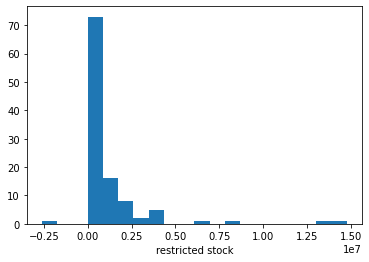

In [51]:
plt.hist(data=enron, x='restricted_stock', bins=20)
plt.xlabel('restricted stock');

In [52]:
enron[enron['restricted_stock']<0]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,stock/sal,stock+lti,stock+lti/sal
BHATNAGAR SANJAY,NaN,523.0,NaN,15456290.0,NaN,NaN,sanjay.bhatnagar@enron.com,15456290.0,NaN,NaN,...,137864.0,1.0,False,NaN,463.0,-2604490.0,137864.0,NaN,NaN,NaN


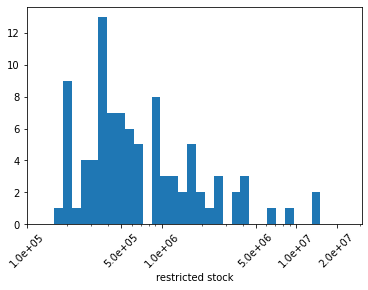

In [53]:
bins = 10**np.arange(5.2,7.4,0.066)
plt.hist(data=enron, x='restricted_stock', bins=bins)
plt.xscale("log")
plt.xlabel("restricted stock")
new_tix = [1e5, 5e5, 1e6, 5e6, 1e7, 2e7]
new_labs = ['{:.1e}'.format(v) for v in new_tix]
plt.xticks(new_tix, new_labs, rotation=45);

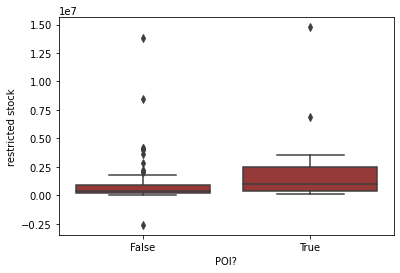

In [54]:
sb.boxplot(data=enron, x='poi', y='restricted_stock', color='brown')
plt.ylabel('restricted stock')
plt.xlabel('POI?');

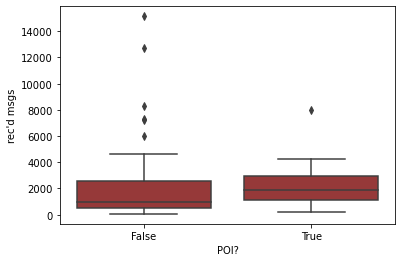

In [55]:
sb.boxplot(data=enron, x='poi', y='to_messages', color='brown')
plt.ylabel("rec'd msgs")
plt.xlabel('POI?');

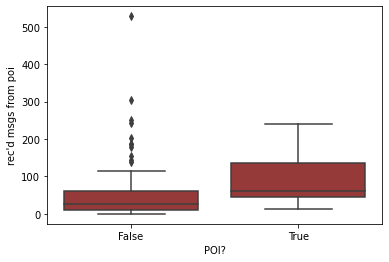

In [56]:
sb.boxplot(data=enron, x='poi', y='from_poi_to_this_person', color='brown')
plt.ylabel("rec'd msgs from poi")
plt.xlabel('POI?');

In [57]:
enron['pct_from_poi'] = enron['from_poi_to_this_person']/enron['to_messages']

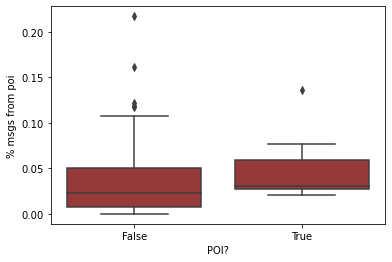

In [58]:
sb.boxplot(data=enron, x='poi', y='pct_from_poi', color='brown')
plt.ylabel("% msgs from poi")
plt.xlabel('POI?');

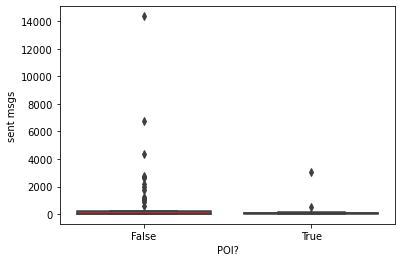

In [59]:
sb.boxplot(data=enron, x='poi', y='from_messages', color='brown')
plt.ylabel("sent msgs")
plt.xlabel('POI?');

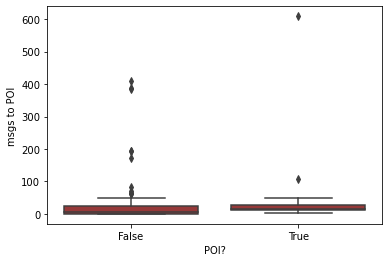

In [60]:
sb.boxplot(data=enron, x='poi', y='from_this_person_to_poi', color='brown')
plt.ylabel("msgs to POI")
plt.xlabel('POI?');

In [61]:
enron['pct_to_poi'] = enron['from_this_person_to_poi']/enron['from_messages']

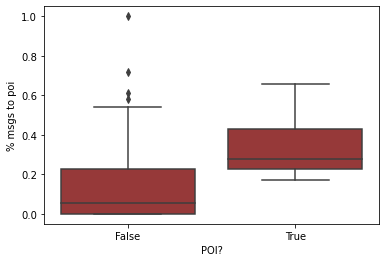

In [62]:
sb.boxplot(data=enron, x='poi', y='pct_to_poi', color='brown')
plt.ylabel("% msgs to poi")
plt.xlabel('POI?');

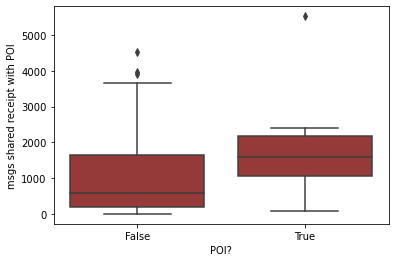

In [63]:
sb.boxplot(data=enron, x='poi', y='shared_receipt_with_poi', color='brown')
plt.ylabel("msgs shared receipt with POI")
plt.xlabel('POI?');

In [64]:
enron['pct_shared_receipt'] = enron['shared_receipt_with_poi']/enron['to_messages']

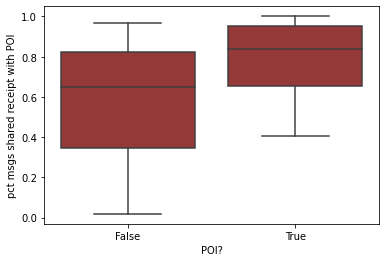

In [65]:
sb.boxplot(data=enron, x='poi', y='pct_shared_receipt', color='brown')
plt.ylabel("pct msgs shared receipt with POI")
plt.xlabel('POI?');

The intrinsic features that appear to be most related to POI status are:
- `salary`
- `total_payments`
- `bonus`

The derived features that I created that seem most promising are:
- `stock+lti` (sum of total stock value and long-term incentives)
- `pct_to_poi` (% of a person's emails that are addresed to a POI)
- `pct_shared_receipt` (% of a person's emails for which they're on a recipient list with a POI)

In [66]:
# keep the fields of interest
keep_list = ['salary', 'total_payments', 'bonus', 'stock+lti', 'pct_to_poi', 'pct_shared_receipt', 'poi']
enron2 = enron[keep_list]
enron2.head()

,salary,total_payments,bonus,stock+lti,pct_to_poi,pct_shared_receipt,poi
METTS MARK,365788.0,1061827.0,600000.0,NaN,0.034483,0.869888,False
BAXTER JOHN C,267102.0,5634343.0,1200000.0,12209313.0,NaN,NaN,False
ELLIOTT STEVEN,170941.0,211725.0,350000.0,NaN,NaN,NaN,False
CORDES WILLIAM R,NaN,NaN,NaN,NaN,0.000000,0.075916,False
HANNON KEVIN P,243293.0,288682.0,1500000.0,8008076.0,0.656250,0.990431,True


sklearn will choke on NaNs. since dataset is so small, don't think imputation makes sense, so will drop entries missing data for cols of interest

In [67]:
# drop the NaNs
enron2.dropna(inplace=True)
enron2.head()

<ipython-input-67-35d6f6851eaf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enron2.dropna(inplace=True)


,salary,total_payments,bonus,stock+lti,pct_to_poi,pct_shared_receipt,poi
HANNON KEVIN P,243293.0,288682.0,1500000.0,8008076.0,0.656250,0.990431,True
MCMAHON JEFFREY,370448.0,4099771.0,2600000.0,2357717.0,0.541667,0.946072,False
HAEDICKE MARK E,374125.0,3859065.0,1150000.0,1786440.0,0.031427,0.460713,False
BLACHMAN JEREMY M,248546.0,2014835.0,850000.0,1786163.0,0.142857,0.939798,False
SUNDE MARTIN,257486.0,1545059.0,700000.0,1175371.0,0.342105,0.969022,False


In [68]:
enron2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, HANNON KEVIN P to GLISAN JR BEN F
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   salary              43 non-null     float64
 1   total_payments      43 non-null     float64
 2   bonus               43 non-null     float64
 3   stock+lti           43 non-null     float64
 4   pct_to_poi          43 non-null     float64
 5   pct_shared_receipt  43 non-null     float64
 6   poi                 43 non-null     bool   
dtypes: bool(1), float64(6)
memory usage: 2.4+ KB


Unfortunately, now the dataseet is really small (N=43). Not sure I'll be able to find much in the way of useful relationships.

In [69]:
labels = enron2['poi']

In [70]:
# How many POIs are there?
labels.sum()

10

In [71]:
feat_list = ['salary', 'total_payments', 'bonus', 'stock+lti', 'pct_to_poi', 'pct_shared_receipt']
features = enron2[feat_list]
features.head()

,salary,total_payments,bonus,stock+lti,pct_to_poi,pct_shared_receipt
HANNON KEVIN P,243293.0,288682.0,1500000.0,8008076.0,0.656250,0.990431
MCMAHON JEFFREY,370448.0,4099771.0,2600000.0,2357717.0,0.541667,0.946072
HAEDICKE MARK E,374125.0,3859065.0,1150000.0,1786440.0,0.031427,0.460713
BLACHMAN JEREMY M,248546.0,2014835.0,850000.0,1786163.0,0.142857,0.939798
SUNDE MARTIN,257486.0,1545059.0,700000.0,1175371.0,0.342105,0.969022


Start super-basic, with Naive Bayes classifier

In [72]:
# split into train/test sets
feat_train, feat_test, lbl_train, lbl_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [73]:
# single run of Naive Bayes
gnb = GaussianNB()
gnb.fit(feat_train, lbl_train)
gnb_pred = gnb.predict(feat_test)
print('GNB accuracy: ', gnb.score(feat_test, lbl_test))
print('GNB precis, recall, f1:', precision_recall_fscore_support(lbl_test, gnb_pred, average='binary'))

GNB accuracy:  0.6666666666666666
GNB precis, recall, f1: (0.4, 0.5, 0.4444444444444445, None)


In [74]:
# see how results change if we use cross-validation
splits = 3
# use stratified since POI is relatively rare
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
gnb_acc = 0
gnb_precis = 0
gnb_recall = 0
gnb_fscore = 0
for i, (train, test) in enumerate(skf.split(features, labels)):
    gnb.fit(features.iloc[train], labels.iloc[train])
    gnb_pred = gnb.predict(features.iloc[test])
    gnb_acc += gnb.score(features.iloc[test], labels.iloc[test])
    print(labels.iloc[test], gnb_pred)
    prf = precision_recall_fscore_support(labels.iloc[test], gnb_pred, average='binary')
    gnb_precis += prf[0]
    gnb_recall += prf[1]
    gnb_fscore += prf[2]
    print(i, gnb_acc, prf)
    
gnb_acc /= splits
gnb_precis /= splits
gnb_recall /= splits
gnb_fscore /= splits

print('Stratified {}-fold X-val GNB: acc {}, precis {}, recall {}, f1 {}'.format(splits, gnb_acc, gnb_precis,\
                                                                      gnb_recall, gnb_fscore))

BLACHMAN JEREMY M      False
SHANKMAN JEFFREY A     False
LEFF DANIEL P          False
WHALLEY LAWRENCE G     False
DELAINEY DAVID W        True
OLSON CINDY K          False
BOWEN JR RAYMOND M      True
FITZGERALD JAY L       False
RICE KENNETH D          True
KAMINSKI WINCENTY J    False
ALLEN PHILLIP K        False
BUCHANAN HAROLD G      False
MURRAY JULIA H         False
FREVERT MARK A         False
CAUSEY RICHARD A        True
Name: poi, dtype: bool [False False False False False False False False  True False False False
 False  True False]
0 0.7333333333333333 (0.5, 0.25, 0.3333333333333333, None)
MCMAHON JEFFREY        False
HAEDICKE MARK E        False
MULLER MARK S          False
HICKERSON GARY J       False
LAVORATO JOHN J        False
SHERRIFF JOHN R        False
MCCONNELL MICHAEL S    False
LAY KENNETH L           True
DURAN WILLIAM D        False
WASAFF GEORGE          False
GARLAND C KEVIN        False
KOENIG MARK E           True
BUY RICHARD B          False
GLISAN JR BEN

In [75]:
splits = 3
# stratified gave poor results; try just plain K-fold
skf = KFold(n_splits=splits, shuffle=True, random_state=42)
gnb_acc = 0
gnb_precis = 0
gnb_recall = 0
gnb_fscore = 0
for i, (train, test) in enumerate(skf.split(features, labels)):
    gnb.fit(features.iloc[train], labels.iloc[train])
    gnb_pred = gnb.predict(features.iloc[test])
    gnb_acc += gnb.score(features.iloc[test], labels.iloc[test])
    prf = precision_recall_fscore_support(labels.iloc[test], gnb_pred, average='binary')
    gnb_precis += prf[0]
    gnb_recall += prf[1]
    gnb_fscore += prf[2]
    print(i, gnb_acc, prf)
    
gnb_acc /= splits
gnb_precis /= splits
gnb_recall /= splits
gnb_fscore /= splits

print('{}-fold X-val GNB: acc {}, precis {}, recall {}, f1 {}'.format(splits, gnb_acc, gnb_precis,\
                                                                      gnb_recall, gnb_fscore))

0 0.6666666666666666 (0.4, 0.5, 0.4444444444444445, None)
1 1.5238095238095237 (0.0, 0.0, 0.0, None)
2 2.238095238095238 (0.0, 0.0, 0.0, None)
3-fold X-val GNB: acc 0.746031746031746, precis 0.13333333333333333, recall 0.16666666666666666, f1 0.14814814814814817


/home/umahp/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/umahp/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Those results sucked. The cross-validation results were worse, probably because I'm splitting a small dataset, so by random bad luck I just get some really low precision and recall.

Try SVM next.

In [76]:
# scale 1st
scaler = MinMaxScaler()
feat_txfrm = scaler.fit_transform(features)
feat_txfrm[0,:]

array([0.05996842, 0.        , 0.16129032, 0.14389431, 1.        ,
       0.98906654])

In [77]:
feattx_train, feattx_test, lbltx_train, lbltx_test = train_test_split(feat_txfrm, labels, test_size=0.33, random_state=42)

This is the best manually-tuned SVM (with single test/train split):

In [78]:
svm_c = 93
svm_krnl = 'rbf'
svm_gam =  0.18
svm = SVC(C=svm_c, kernel=svm_krnl, gamma=svm_gam)
svm.fit(feattx_train, lbltx_train)
svm_pred = svm.predict(feattx_test)
#print(lbltx_test, svm_pred)
print('SVM accuracy: ', svm.score(feattx_test, lbltx_test))
print('SVM precis, recall, f1:', precision_recall_fscore_support(lbltx_test, svm_pred, average='binary'))

SVM accuracy:  0.7333333333333333
SVM precis, recall, f1: (0.5, 0.5, 0.5, None)


Try some auto-tuning. The values below are adjacent to the manual tuning above. I tried multiple ranges of C and gamma, but didn't get better results than what are below.

In [80]:
svc_params = {'kernel':['rbf','linear'], 'C':[90, 95, 100], 'gamma':[0.18, 0.2, 0.22]}
clf = GridSearchCV(SVC(), svc_params, scoring='f1')
clf.fit(feattx_train, lbltx_train)


GridSearchCV(estimator=SVC(),
             param_grid={'C': [90, 95, 100], 'gamma': [0.18, 0.2, 0.22],
                         'kernel': ['rbf', 'linear']},
             scoring='f1')

In [81]:
display(clf.best_score_)
display(clf.best_params_)

0.6333333333333333

{'C': 90, 'gamma': 0.18, 'kernel': 'linear'}

In [82]:
svr_pred = clf.predict(feattx_test)
print('SVM accuracy: ', clf.score(feattx_test, lbltx_test))
print('SVM precis, recall, f1:', precision_recall_fscore_support(lbltx_test, svr_pred, average='binary'))

SVM accuracy:  0.4
SVM precis, recall, f1: (0.3333333333333333, 0.5, 0.4, None)


Try PCA. Going to start with 2 components since there is a "payment" and an "email" aspect to the data.

However, 4 components gave best "performance" vs. 2, 3, 5 (only 6 feats total so no point doing that)

In [83]:
n_comps = 4
pca = PCA(n_components=n_comps, svd_solver='randomized').fit(feattx_train)
feat_train_pca = pca.transform(feattx_train)
feat_test_pca = pca.transform(feattx_test)
pca.explained_variance_ratio_

array([0.48300657, 0.37941975, 0.09138431, 0.03088038])

The parameters below are roughly the best are several tries of different ranges.

In [84]:
svc_params = {'kernel':['rbf','linear'], 'C':[171, 172, 173, 174, 175, 176, 178, 180, 185, 190], 'gamma':[0.01, 0.1, 1, 10, 100, 1000]}
clf2 = GridSearchCV(SVC(), svc_params, scoring='f1')
clf2.fit(feattx_train, lbltx_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [171, 172, 173, 174, 175, 176, 178, 180, 185,
                               190],
                         'gamma': [0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['rbf', 'linear']},
             scoring='f1')

In [85]:
clf2.fit(feat_train_pca, lbltx_train)
display(clf2.best_score_)
display(clf2.best_params_)

0.6333333333333333

{'C': 175, 'gamma': 0.01, 'kernel': 'linear'}

In [86]:
svr_pred = clf2.predict(feat_test_pca)
print('SVM accuracy: ', clf2.score(feat_test_pca, lbltx_test))
print('SVM precis, recall, f1:', precision_recall_fscore_support(lbltx_test, svr_pred, average='binary'))

SVM accuracy:  0.4444444444444445
SVM precis, recall, f1: (0.4, 0.5, 0.4444444444444445, None)


#### Summary

After selecting several intrinsic and derived features that appeared to predict POI status on graphical exploration, I ran the final data through the ML algorithms.

Unfortunately, dropping all the NaNs left only 43 people (10 POI, 33 non-POI) in the final dataset. With these data the best results achieved were:
- accuracy 0.73
- precision, recall, and f1 score 0.5

This was for an SVM model with an RBF kernel. Parameters were `gamma`=0.18 and `C`=93.
These results were obtained with a single train/test split of 0.67/0.33. 
When cross-validating or grid search for optimal parameters were used, the results were degraded because the model seemed sensitive to how the data were split. This is probably a consequence of the small size of the dataset. 
Using PCA to reduce the dimensionality and/or find latent features also failed to produce better results.